# Sierpinski Triangle (Fractal)

In this notebook we are gonna try to achieve two objectives

- Create and Undertand a basic OpenGL + GLFW program
- Create a Sierpinsk Triangle using a Chaos Game and simple dots

In [1]:
# Basic configurations to use along the program
WINDOW_WIDTH = 600
WINDOW_HEIGHT = 600
NUMBER_OF_DOTS = 100000

# Part 1 - Prepare a Window using GLFW 

In [2]:
import glfw
from OpenGL.GL import *
import OpenGL.GL.shaders
import numpy as np

The first thing we need to do is create a Window object with the desirable settings with the GLFW API.

*Obs: the window is not visible yet. It will appear when all the shaders and fragments finish loading*

In [3]:
# Starting the GLFW Windows (Communicate with the X Terminal API)
glfw.init()
glfw.window_hint(glfw.VISIBLE, glfw.FALSE)
glfw.window_hint(glfw.RESIZABLE, glfw.FALSE)
window = glfw.create_window(WINDOW_WIDTH, WINDOW_HEIGHT, "Sierpinski Fractal", None, None)
glfw.make_context_current(window)

# Part 2  - Prepare the OpenGL program

When working with OpenGL we need to use the GLSL (OpenGL Shading Language), a C-like graphic program language that helps us to create shaders and fragments to be compiled, linked and used on ours GPU or graphic processor unity.

We can think a shader as a mini-program that will execute every time we want to print different primitives and forms using our program.

First we need to create a program and prepare a vertex and a fragment shader to be used on this notebook.

In [4]:
# Request a program and shader slots from GPU
program  = glCreateProgram()
vertex   = glCreateShader(GL_VERTEX_SHADER)
fragment = glCreateShader(GL_FRAGMENT_SHADER)

Now lets create our Vertex Shader that will help us to render all the dots. For this we just need a basic program that receive 2D-positions for each point. 

We also will need the three starting points to create our outer triangle.

In [5]:
vertex_code = """
    attribute vec2 position;
    void main(){ 
        gl_Position = vec4(position, 0.0, 1.0);
    }
"""

We also need to create a fragment for the vertex, the fragment will define some properties like the color of the dots.

In [6]:
fragment_code = """
    attribute vec3 color;
    void main(){
        gl_FragColor = vec4(0.0, 0.0, 0.0, 1.0);
    }
"""

In [7]:
# Set shaders source code
glShaderSource(vertex, vertex_code)
glShaderSource(fragment, fragment_code)

# Compiling vertex shader
glCompileShader(vertex)
if not glGetShaderiv(vertex, GL_COMPILE_STATUS):
    error = glGetShaderInfoLog(vertex).decode()
    print(error)
    raise RuntimeError("Erro de compilacao do Vertex Shader")

# Compile fragment shader
glCompileShader(fragment)
if not glGetShaderiv(fragment, GL_COMPILE_STATUS):
    error = glGetShaderInfoLog(fragment).decode()
    print(error)
    raise RuntimeError("Erro de compilacao do Fragment Shader")
    
# If success atach the compiled codes to the program
glAttachShader(program, vertex)
glAttachShader(program, fragment)

# Build program
glLinkProgram(program)
if not glGetProgramiv(program, GL_LINK_STATUS):
    print(glGetProgramInfoLog(program))
    raise RuntimeError('Linking error')
    
# Make program the default program
glUseProgram(program)

# Part 3 - Compute the Sierpinski Fractal with Random Points

Using a chaos game, we can start the following rules to draw a Sierpinski fractal:

1. Pick an initial point p = (x, y, 0) at random inside the triangle.
2. Select one of the three vertices at random.
3. Find the point q halfway between p and the randomly selected vertex.
4. Display q by putting some sort of marker, such as a small circle, at the corresponding location on the display.
5. Replace p with q.
6. Return to step 2 until N dots are printed in the screen

*Algorithm Font: ANGEL - Interactive Computer Graphics*

In [8]:
import random

# Init all variables needed
triangle    = np.zeros(3, [("position", np.float32, 2)])
vertices    = np.zeros(NUMBER_OF_DOTS, [("position", np.float32, 2)])

# Start tringle edges and start point
triangle['position'] = [(-1.0, -1.0), (0.0, 1.0), (1.0, -1.0) ]
vertices['position'][0] = (0.25, 0.50)

# Select the follow (N-1) random points
for i in range(1, NUMBER_OF_DOTS): 
    v = random.randint(0,2)
    # Compute the point halfway between the selected vertex
    vertices['position'][i] = (vertices['position'][i-1] + triangle['position'][v]) / 2.0
    

# Part 4 - Request the Buffer and send values to GPU

Now that our program already has all the point already computed we need to ask the gpu to reserve some space and send all the values. For this we are gonna use the OpenGL API as show bellow.

In [9]:
# Request a buffer slot from GPU and make it the default one
buffer = glGenBuffers(1)
glBindBuffer(GL_ARRAY_BUFFER, buffer)
                      
# Send the point to buffer
glBufferData(GL_ARRAY_BUFFER, vertices.nbytes, vertices, GL_DYNAMIC_DRAW)                 

At least, we need to request OpenGL to locate the `positions` variable in our loaded vertex shader so we can associate the `vertices[]` values to the shader when ask the GPU to print the primitives.

*Obs: I'm not so sure why we need the stride but lets ignore this right now`

In [10]:
# get some important values because reasons
stride = vertices.strides[0]
offset = ctypes.c_void_p(0)

# get position variable location
loc = glGetAttribLocation(program, "position")
glEnableVertexAttribArray(loc)

# Bind the position to loc, here we say that we want a two positions Float values
glVertexAttribPointer(loc, 2, GL_FLOAT, False, stride, offset)

# Part 5 - Show the Window and Print the Fractal

In [11]:
glfw.show_window(window)

while not glfw.window_should_close(window):
    # Event poll (not using right now but cannot be removed from this loop!!!)
    glfw.poll_events() 
    
    # Reset the screen with the white color
    glClear(GL_COLOR_BUFFER_BIT) 
    glClearColor(1.0, 1.0, 1.0, 1.0)
    
    # Draw all the points
    glDrawArrays(GL_POINTS, 0, NUMBER_OF_DOTS)

    glfw.swap_buffers(window)
glfw.terminate()

If everything gone well we should see the result as the image below:

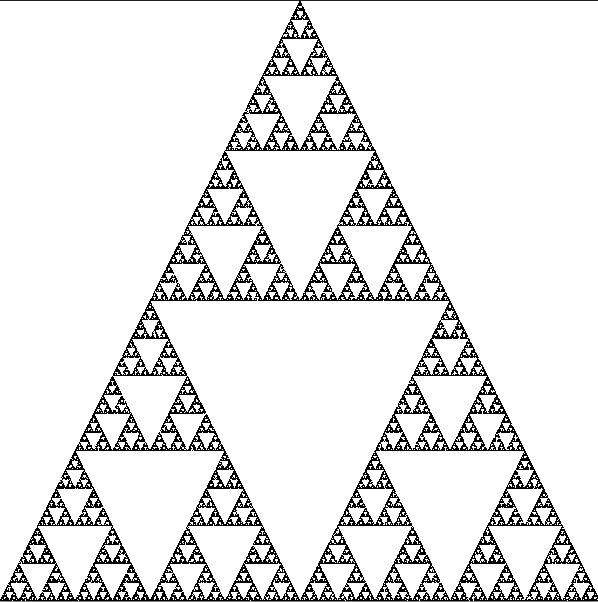

And that is it, we done a awesome fractal with only dots and OpenGL